In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_df_train = '/content/drive/MyDrive/MLOps/Proyecto Fase 1/df_train.csv'
path_df_test = '/content/drive/MyDrive/MLOps/Proyecto Fase 1/df_test.csv'
path_df_val = '/content/drive/MyDrive/MLOps/Proyecto Fase 1/df_valid.csv'

df_train = pd.read_csv(path_df_train)
df_test = pd.read_csv(path_df_test)
df_valid = pd.read_csv(path_df_val)

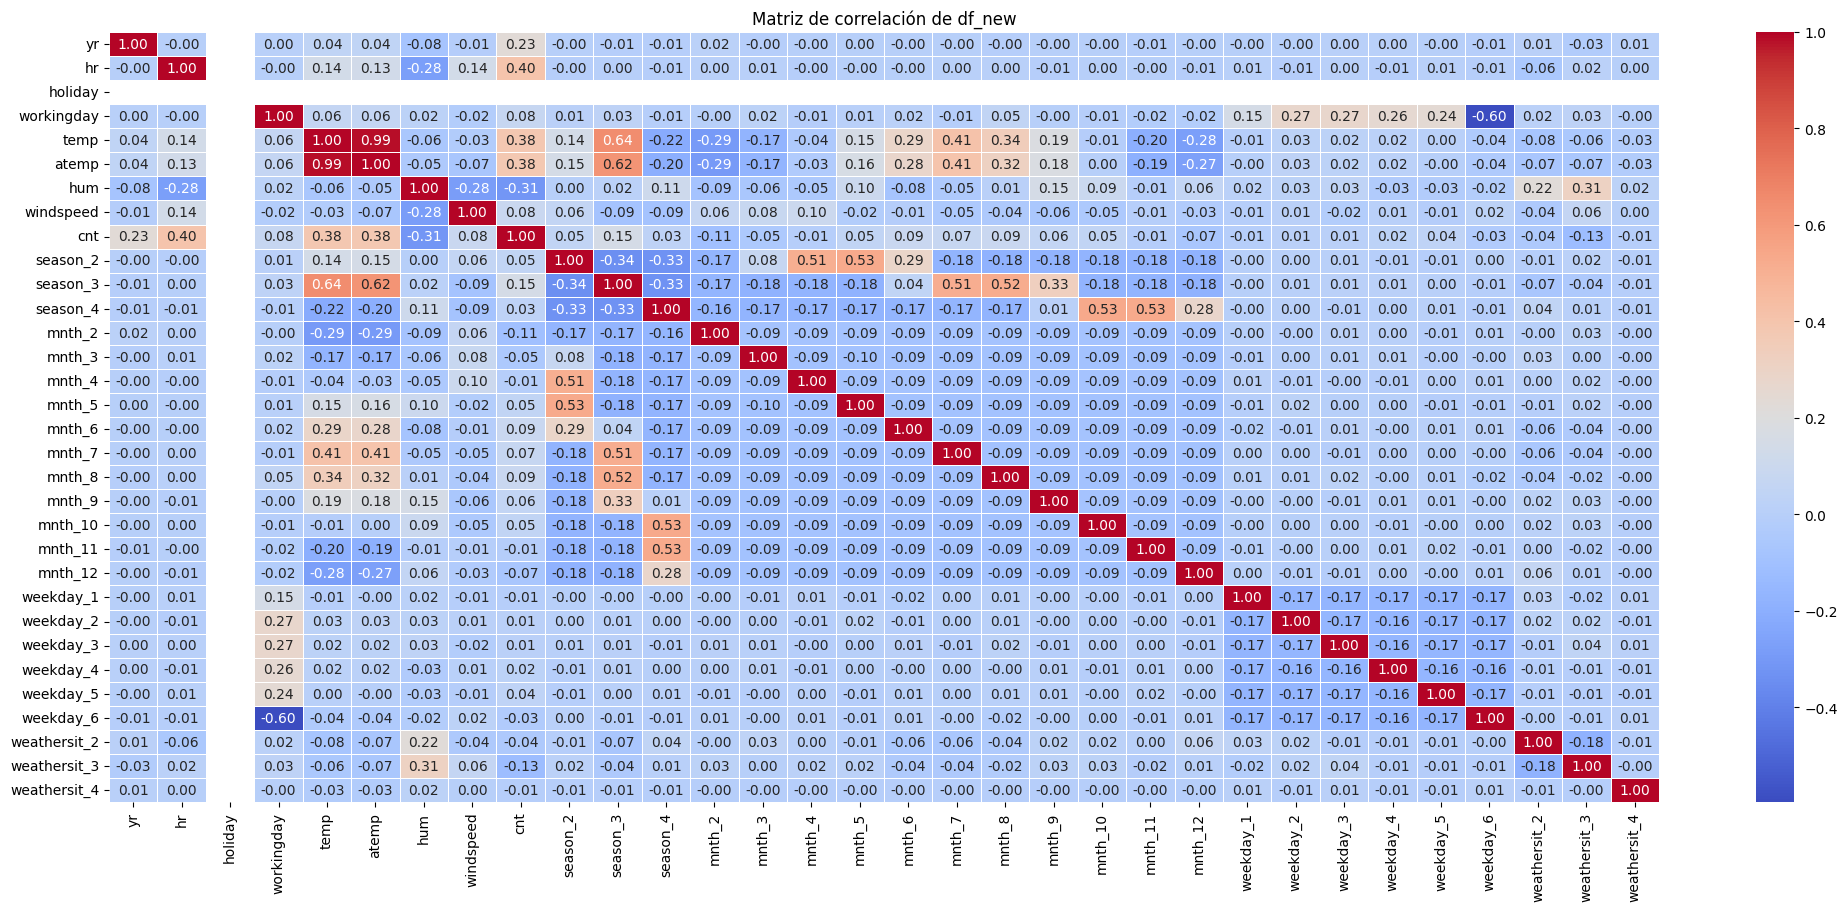

In [4]:
#Generamos una matriz de correlación de todas las variables
correlation_matrix = df_train.corr(numeric_only=True)

plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de correlación de df_new')
plt.show()

# Multiple Linear Regression

In [5]:
#La variable objetivo es cnt por lo que la eliminamos de las características
y_train = df_train.pop('cnt')
X_train = df_train

In [6]:
# Definimos la malla de parámetros para el Grid Search
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

#Inicializamos el modelo de regresión lineal
modelo_LR = LinearRegression()

#Inicializamos el GridSearch con el modelo y la malla de parámetros usando RMSE y MAE como métricas de error
grid_search = GridSearchCV(estimator=modelo_LR, param_grid=param_grid,
                           scoring={'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                                    'neg_mean_absolute_error': 'neg_mean_absolute_error'},
                           refit='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Imputamos los valores faltantes con la mediana antes de ajustar el Grid Search
for col in ['yr', 'hr', 'holiday', 'workingday']:
    if col in X_train.columns:
        X_train[col] = X_train[col].fillna(X_train[col].median())

#Ajusta el Grid Search a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros y el mejor puntaje
print("Mejores parámetros encontrados: ", grid_search.best_params_)
print("Mejor RMSE encontrado: ", -grid_search.best_score_)

# Evalúa el modelo en el conjunto de validación
# Separa características y objetivo en df_valid
y_valid = df_valid['cnt']
X_valid = df_valid.drop('cnt', axis=1)


# Imputamos valores faltantes en el conjunto de validación
for col in ['yr', 'hr', 'holiday', 'workingday']:
    if col in X_valid.columns:
        X_valid[col] = X_valid[col].fillna(X_valid[col].median())


# Hacemos predicción en el conjunto de validación.
yhat_valid = grid_search.predict(X_valid)

# Calculamos e imprimimos RMSE y MAE en el conjunto de validación
rmse_valid = np.sqrt(mean_squared_error(y_valid, yhat_valid))
mae_valid = mean_absolute_error(y_valid, yhat_valid)

print(f"RMSE on validation set: {rmse_valid:.2f}")
print(f"MAE on validation set: {mae_valid:.2f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros encontrados:  {'copy_X': True, 'fit_intercept': True}
Mejor RMSE encontrado:  0.095064138237793
RMSE on validation set: 0.09
MAE on validation set: 0.07


In [7]:
filename = 'modelo_LR.pickle'
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))

In [8]:
# Load the model from the pickle file
filename = 'modelo_LR.pickle'
loaded_model = pickle.load(open(filename, 'rb'))

# You can now use 'loaded_model' for predictions or further evaluation
print("Model loaded successfully!")

Model loaded successfully!


In [9]:
# Evaluate the model on the test set (df_test)
# Separate features and target in df_test
y_test = df_test['cnt']
X_test = df_test.drop('cnt', axis=1)

# Impute values faltantes in the test set
for col in ['yr', 'hr', 'holiday', 'workingday']:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna(X_test[col].median())

# Make predictions del test set
yhat_test = loaded_model.predict(X_test)

# Calculate e imprime RMSE y MAE con el test set
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
mae_test = mean_absolute_error(y_test, yhat_test)

print(f"RMSE on test set: {rmse_test:.2f}")
print(f"MAE on test set: {mae_test:.2f}")

RMSE on test set: 0.10
MAE on test set: 0.07


##Lasso Linear Regression

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Definimos la malla de parámetros para el Grid Search para Lasso
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'max_iter': [1000, 5000, 10000]
}

#Se inicializa el modelo Lasso
modelo_lasso = Lasso(random_state = 200)

#Se inicializa GridSearchCV para Lasso
grid_search_lasso = GridSearchCV(estimator=modelo_lasso, param_grid=param_grid_lasso,
                                 scoring={'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                                          'neg_mean_absolute_error': 'neg_mean_absolute_error'},
                                 refit='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1)


# Imputamos los valores faltantes con la mediana antes de ajustar el Grid Search
for col in ['yr', 'hr', 'holiday', 'workingday']:
    if col in X_train.columns:
        X_train[col] = X_train[col].fillna(X_train[col].median())

# Se ajusta GS a los datos de entrenamiento
grid_search_lasso.fit(X_train, y_train)

# Obtenemos los mejores parámetros y el mejor puntaje
print("Mejores parámetros encontrados para Lasso: ", grid_search_lasso.best_params_)
print("Mejor RMSE encontrado para Lasso: ",-grid_search_lasso.best_score_)

# Evalúa el modelo en el conjunto de validación
# Separa características y objetivo en df_valid
y_valid = df_valid['cnt']
X_valid = df_valid.drop('cnt', axis=1)


# Imputamos valores faltantes en el conjunto de validación
for col in ['yr', 'hr', 'holiday', 'workingday']:
    if col in X_valid.columns:
        X_valid[col] = X_valid[col].fillna(X_valid[col].median())


# Hacemos predicción en el conjunto de validación.
yhat_valid = grid_search_lasso.predict(X_valid)

# Calculamos e imprimimos RMSE y MAE en el conjunto de validación
rmse_valid = np.sqrt(mean_squared_error(y_valid, yhat_valid))
mae_valid = mean_absolute_error(y_valid, yhat_valid)

print(f"RMSE on validation set: {rmse_valid:.2f}")
print(f"MAE on validation set: {mae_valid:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros encontrados para Lasso:  {'alpha': 0.001, 'copy_X': True, 'fit_intercept': False, 'max_iter': 1000}
Mejor RMSE encontrado para Lasso:  0.09588294640042336
RMSE on validation set: 0.09
MAE on validation set: 0.07


In [11]:
# Se evalúa el mejor modelo Lasso en el coinjunto de prueba
yhat_test_lasso = grid_search_lasso.predict(X_test)

# Se calcula e imprime RMSE y MAE el el conjunto de prueba para Lasso
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, yhat_test_lasso))
mae_test_lasso = mean_absolute_error(y_test, yhat_test_lasso)

print(f"RMSE on test set (Lasso): {rmse_test_lasso:.2f}")
print(f"MAE on test set (Lasso): {mae_test_lasso:.2f}")

RMSE on test set (Lasso): 0.10
MAE on test set (Lasso): 0.07


##Ridge Linear Regression

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#Definimos la malla de parámetros para el Grid Search para Ridge
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'max_iter': [1000, 5000, 10000]
}

#Se inicializa el modelo Ridge
modelo_ridge = Ridge(random_state=200)

#Se inicializa GridSearchCV para Ridge
grid_search_ridge = GridSearchCV(estimator=modelo_ridge, param_grid=param_grid_ridge,
                                 scoring={'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                                          'neg_mean_absolute_error': 'neg_mean_absolute_error'},
                                 refit='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Se ajusta GS a los datos de entrenamiento
grid_search_ridge.fit(X_train, y_train)

# Obtenemos los mejores parámetros y el mejor puntaje
print("Best parameters for Ridge found: ", grid_search_ridge.best_params_)
print("Best RMSE for Ridge found: ", -grid_search_ridge.best_score_)


# Evalúa el modelo en el conjunto de validación
# Separa características y objetivo en df_valid
y_valid = df_valid['cnt']
X_valid = df_valid.drop('cnt', axis=1)

# Imputamos valores faltantes en el conjunto de validación
for col in ['yr', 'hr', 'holiday', 'workingday']:
    if col in X_valid.columns:
        X_valid[col] = X_valid[col].fillna(X_valid[col].median())

# Hacemos predicción en el conjunto de validación.
yhat_valid = grid_search_ridge.predict(X_valid)

# Calculamos e imprimimos RMSE y MAE en el conjunto de validación
rmse_valid = np.sqrt(mean_squared_error(y_valid, yhat_valid))
mae_valid = mean_absolute_error(y_valid, yhat_valid)

print(f"RMSE on validation set: {rmse_valid:.2f}")
print(f"MAE on validation set: {mae_valid:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Ridge found:  {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000}
Best RMSE for Ridge found:  0.09506322338920326
RMSE on validation set: 0.09
MAE on validation set: 0.07


In [13]:
# Se evalúa el mejor modelo ridge en el coinjunto de prueba
yhat_test_ridge = grid_search_ridge.predict(X_test)

# Se calcula e imprime RMSE y MAE el el conjunto de prueba para ridge
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, yhat_test_ridge))
mae_test_ridge = mean_absolute_error(y_test, yhat_test_ridge)

print(f"RMSE on test set (Ridge): {rmse_test_ridge:.2f}")
print(f"MAE on test set (Ridge): {mae_test_ridge:.2f}")

RMSE on test set (Ridge): 0.10
MAE on test set (Ridge): 0.07
